# Hotel Price Recommendation Model
## Technical Documentation for Stakeholders

---

**Objective**: Optimize hotel Revenue Per Available Room (RevPAR) through intelligent price recommendations

**Key Result**: 82% win rate on cold-start hotels, with +€21 average RevPAR lift compared to baseline strategies


## 1. Executive Summary

### The Problem
Hotels need to set optimal prices that maximize revenue. Pricing too high leads to empty rooms; pricing too low leaves money on the table.

**RevPAR = Average Daily Rate × Occupancy Rate**

### Our Solution
An ML-based recommendation system that:
1. Learns from peer hotels with similar characteristics
2. Predicts how occupancy changes with price (demand elasticity)
3. Finds the price that maximizes RevPAR

### Key Results

| Metric | Baseline (Segment Avg) | ML Model | Improvement |
|--------|------------------------|----------|-------------|
| Win Rate | 58% | **82%** | +24 pts |
| Mean Lift | -€11.47 | **+€21.40** | +€33 |

The model works on **cold-start hotels** (hotels with no booking history in our system).


## 2. System Architecture

```
┌─────────────────────────────────────────────────────────────────────────┐
│                     PRICE RECOMMENDATION PIPELINE                        │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  ┌──────────────┐     ┌──────────────┐     ┌──────────────────┐        │
│  │  RAW DATA    │     │   FEATURE    │     │  PEER MATCHING   │        │
│  │              │────▶│ ENGINEERING  │────▶│                  │        │
│  │ • Bookings   │     │              │     │ • Geographic     │        │
│  │ • Locations  │     │ • Room size  │     │ • KNN (features) │        │
│  │ • Rooms      │     │ • Amenities  │     │ • Segment        │        │
│  └──────────────┘     │ • Location   │     └────────┬─────────┘        │
│                       │ • Temporal   │              │                  │
│                       └──────────────┘              │                  │
│                                                     ▼                  │
│                                         ┌──────────────────┐           │
│                                         │    OCCUPANCY     │           │
│                                         │   PREDICTION     │           │
│                                         │                  │           │
│                                         │  CatBoost model  │           │
│                                         │  R² = 0.70       │           │
│                                         └────────┬─────────┘           │
│                                                  │                     │
│                                                  ▼                     │
│                                         ┌──────────────────┐           │
│                                         │     PRICE        │           │
│                                         │  OPTIMIZATION    │           │
│                                         │                  │           │
│                                         │ Grid search with │           │
│                                         │ elasticity       │           │
│                                         └────────┬─────────┘           │
│                                                  │                     │
│                                                  ▼                     │
│                                         ┌──────────────────┐           │
│                                         │  RECOMMENDED     │           │
│                                         │     PRICE        │           │
│                                         │                  │           │
│                                         │ Optimal RevPAR   │           │
│                                         └──────────────────┘           │
│                                                                        │
└────────────────────────────────────────────────────────────────────────┘
```


In [4]:
%load_ext autoreload
%autoreload 2
# Setup and imports
import sys
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Setup complete")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Setup complete


In [5]:
# Load data
from src.models.evaluation.time_backtest import BacktestConfig, load_hotel_week_data
from src.features.engineering import get_market_segment

config = BacktestConfig()
full_df = load_hotel_week_data(config, split='all')

# Load distance features
dist_df = pd.read_csv(PROJECT_ROOT / 'outputs/data/hotel_distance_features.csv')
full_df = full_df.merge(dist_df, on='hotel_id', how='left')

# Add market segment (uses lat/lon fallback for hotels missing from distance_features.csv)
full_df['market_segment'] = full_df.apply(
    lambda r: get_market_segment(
        r.get('distance_from_coast'),
        r.get('distance_from_madrid'),
        r.get('latitude'),
        r.get('longitude')
    ), axis=1
)

print(f"Loaded {len(full_df):,} booking records")
print(f"Hotels: {full_df['hotel_id'].nunique():,}")
print(f"Date range: {full_df['week_start'].min().date()} to {full_df['week_start'].max().date()}")


Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting
Loaded 59,954 hotel-week records for 1,987 hotels
  Date range: 2023-05-29 00:00:00 to 2024-09-30 00:00:00
Loaded 59,954 booking records
Hotels: 1,987
Date range: 2023-05-29 to 2024-09-30


## 3. Data Overview


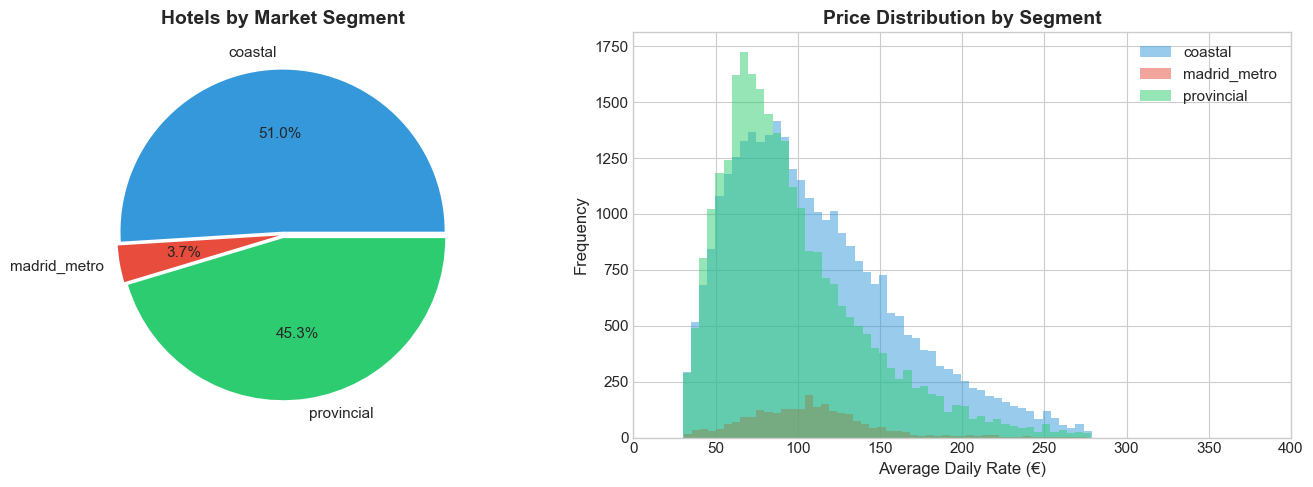


Segment Summary:
                Hotels  Median Price (€)  Median Occupancy
market_segment                                            
coastal           1013            100.64               1.0
madrid_metro        73            104.77               1.0
provincial         901             85.77               0.8


In [6]:
# Hotels by market segment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment distribution
segment_counts = full_df.groupby('market_segment')['hotel_id'].nunique()
colors = {'coastal': '#3498db', 'madrid_metro': '#e74c3c', 'provincial': '#2ecc71', 'unknown': '#95a5a6'}
segment_colors = [colors.get(s, '#95a5a6') for s in segment_counts.index]

axes[0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', 
            colors=segment_colors, explode=[0.02]*len(segment_counts))
axes[0].set_title('Hotels by Market Segment', fontsize=14, fontweight='bold')

# Price distribution by segment
for segment in ['coastal', 'madrid_metro', 'provincial']:
    if segment in full_df['market_segment'].unique():
        subset = full_df[full_df['market_segment'] == segment]['avg_price']
        axes[1].hist(subset, bins=50, alpha=0.5, label=segment, color=colors[segment])

axes[1].set_xlabel('Average Daily Rate (€)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Price Distribution by Segment', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, 400)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_segment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print("\nSegment Summary:")
print(full_df.groupby('market_segment').agg({
    'hotel_id': 'nunique',
    'avg_price': 'median',
    'occupancy_rate': 'median'
}).rename(columns={'hotel_id': 'Hotels', 'avg_price': 'Median Price (€)', 'occupancy_rate': 'Median Occupancy'}).round(2))


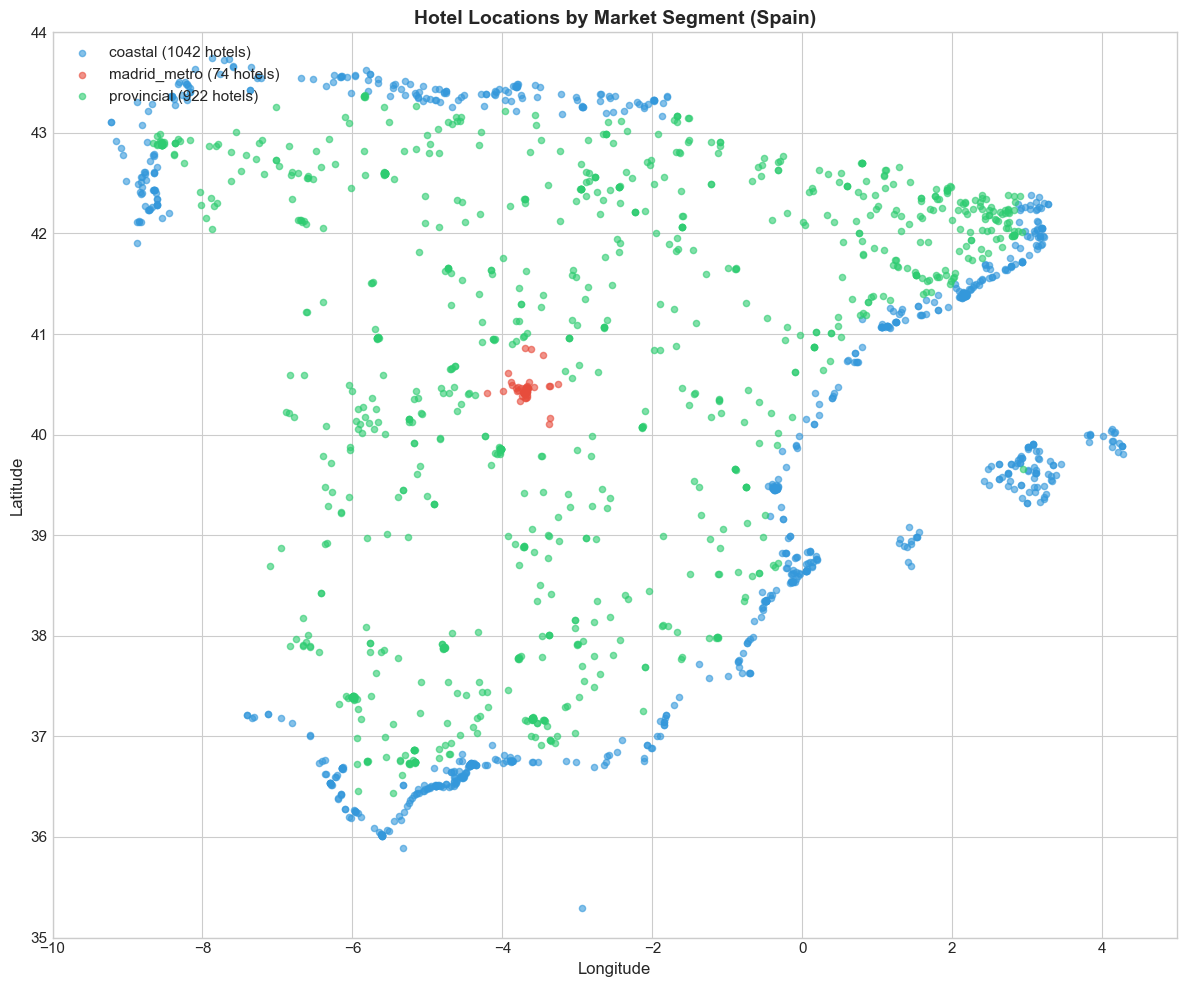

In [4]:
# Geographic map of hotels
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique hotels with their most common segment
hotel_locations = full_df.groupby('hotel_id').agg({
    'latitude': 'first',
    'longitude': 'first',
    'market_segment': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown',
    'avg_price': 'median'
}).reset_index()

for segment in ['coastal', 'madrid_metro', 'provincial']:
    subset = hotel_locations[hotel_locations['market_segment'] == segment]
    ax.scatter(subset['longitude'], subset['latitude'], 
               alpha=0.6, s=20, label=f"{segment} ({len(subset)} hotels)",
               c=colors.get(segment, '#95a5a6'))

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Hotel Locations by Market Segment (Spain)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')

# Spain approximate bounds
ax.set_xlim(-10, 5)
ax.set_ylim(35, 44)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_hotel_map.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Pricing Analysis

### How many hotels are over/under-priced?

We compare each hotel's actual price to their **segment peers** (hotels in the same market segment).


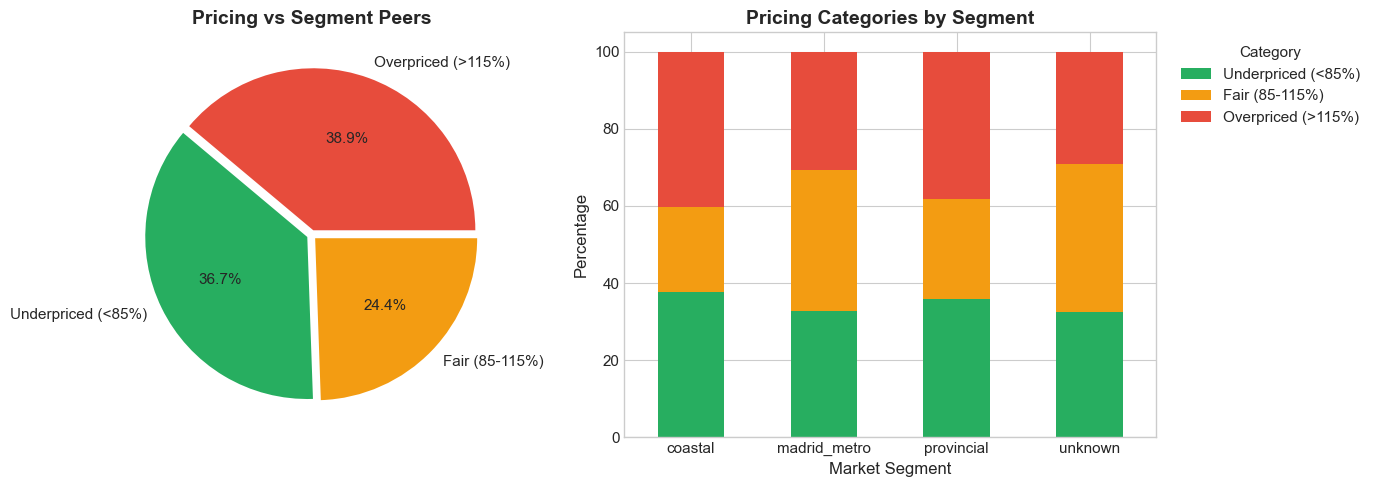


Pricing Distribution:
  Underpriced (<85%): 22,551 records (36.7%)
  Fair (85-115%): 15,034 records (24.4%)
  Overpriced (>115%): 23,923 records (38.9%)


In [5]:
# Compute pricing vs segment peers
segment_medians = full_df.groupby('market_segment')['avg_price'].median()
full_df['segment_median_price'] = full_df['market_segment'].map(segment_medians)
full_df['price_vs_segment'] = full_df['avg_price'] / full_df['segment_median_price']

# Classify pricing
def classify_pricing(ratio):
    if ratio < 0.85:
        return 'Underpriced (<85%)'
    elif ratio > 1.15:
        return 'Overpriced (>115%)'
    else:
        return 'Fair (85-115%)'

full_df['pricing_category'] = full_df['price_vs_segment'].apply(classify_pricing)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of pricing categories
pricing_counts = full_df['pricing_category'].value_counts()
pricing_colors = {
    'Underpriced (<85%)': '#27ae60',  # Green - opportunity
    'Fair (85-115%)': '#f39c12',       # Yellow - neutral
    'Overpriced (>115%)': '#e74c3c'    # Red - risky
}
pie_colors = [pricing_colors[cat] for cat in pricing_counts.index]

wedges, texts, autotexts = axes[0].pie(
    pricing_counts, 
    labels=pricing_counts.index, 
    autopct='%1.1f%%',
    colors=pie_colors,
    explode=[0.03]*len(pricing_counts)
)
axes[0].set_title('Pricing vs Segment Peers', fontsize=14, fontweight='bold')

# Bar chart by segment
pricing_by_segment = pd.crosstab(full_df['market_segment'], full_df['pricing_category'], normalize='index') * 100
pricing_by_segment = pricing_by_segment.reindex(columns=['Underpriced (<85%)', 'Fair (85-115%)', 'Overpriced (>115%)'], fill_value=0)

pricing_by_segment.plot(kind='bar', stacked=True, ax=axes[1], 
                        color=[pricing_colors[c] for c in pricing_by_segment.columns])
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].set_xlabel('Market Segment', fontsize=12)
axes[1].set_title('Pricing Categories by Segment', fontsize=14, fontweight='bold')
axes[1].legend(title='Category', bbox_to_anchor=(1.02, 1))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_pricing_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\nPricing Distribution:")
for cat in ['Underpriced (<85%)', 'Fair (85-115%)', 'Overpriced (>115%)']:
    count = pricing_counts.get(cat, 0)
    pct = count / len(full_df) * 100
    print(f"  {cat}: {count:,} records ({pct:.1f}%)")


In [12]:
full_df[full_df.market_segment == 'unknown']['hotel_id'].value_counts()

hotel_id
7411     34
20276    32
2226     18
9842     15
11180    10
5681      6
2112      1
5699      1
Name: count, dtype: int64

In [ ]:
# Scatter: Price ratio vs Occupancy
fig, ax = plt.subplots(figsize=(12, 6))

for segment in ['coastal', 'madrid_metro', 'provincial']:
    if segment in full_df['market_segment'].unique():
        subset = full_df[full_df['market_segment'] == segment].sample(
            min(1000, len(full_df[full_df['market_segment'] == segment])), random_state=42)
        ax.scatter(subset['price_vs_segment'], subset['occupancy_rate'],
                   alpha=0.3, s=15, label=segment, c=colors.get(segment))

# Add reference lines
ax.axvline(0.85, color='green', linestyle='--', alpha=0.7, label='Underpriced threshold')
ax.axvline(1.15, color='red', linestyle='--', alpha=0.7, label='Overpriced threshold')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Price vs Segment Median (ratio)', fontsize=12)
ax.set_ylabel('Occupancy Rate', fontsize=12)
ax.set_title('Price Positioning vs Occupancy', fontsize=14, fontweight='bold')
ax.set_xlim(0, 3)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_price_vs_occupancy.png', dpi=150, bbox_inches='tight')
plt.show()

# Key insight
print("\n📊 Key Insight:")
print("Hotels pricing below segment median tend to have higher occupancy,")
print("but may be leaving money on the table. The model identifies these opportunities.")


## 5. Model Explanation

### Why predict `rooms_booked` instead of `occupancy_rate`?

**Problem with occupancy_rate**:
- A 4-room hotel can only have occupancy values: 0%, 25%, 50%, 75%, 100%
- A 100-room hotel has much finer granularity: 0%, 1%, 2%, ..., 100%

This creates a **capacity artifact** where small hotels appear to have higher variance.

**Solution**: Predict `rooms_booked` (the actual count), then divide by capacity:
```
occupancy = rooms_booked / total_rooms
```

### KNN Peer Matching

For cold-start hotels (no booking history), we find similar hotels using:

| Feature | Description | Weight |
|---------|-------------|--------|
| `log_room_size` | Room square meters | High |
| `amenities_score` | Children, pets, events allowed | Medium |
| `view_quality_ordinal` | Ocean > Mountain > Pool > None | Medium |
| `log_total_rooms` | Hotel capacity | Medium |
| `dist_coast_km` | Distance from coast | High |

We find the K=10 most similar hotels and use their median price/occupancy as reference.


In [ ]:
# Train the model for demonstration
from src.models.vectorized_predictor import VectorizedOccupancyPredictor

# Split by hotel (cold-start simulation)
hotel_ids = full_df['hotel_id'].unique()
np.random.seed(42)
np.random.shuffle(hotel_ids)
train_hotels = hotel_ids[:int(len(hotel_ids)*0.8)]
test_hotels = hotel_ids[int(len(hotel_ids)*0.8):]

train_df = full_df[full_df['hotel_id'].isin(train_hotels)]
test_df = full_df[full_df['hotel_id'].isin(test_hotels)]

print(f"Training hotels: {len(train_hotels)} (80%)")
print(f"Test hotels (cold-start): {len(test_hotels)} (20%)")

# Train model
predictor = VectorizedOccupancyPredictor(peer_method='knn')
predictor.fit(train_df, verbose=True)


### Price Elasticity

**Elasticity** measures how occupancy changes when price changes:

```
new_occupancy = base_occupancy × (1 + elasticity × price_change%)
```

We use **segment-adjusted elasticity**:

| Segment | Elasticity | Meaning |
|---------|------------|----------|
| Coastal | -0.45 | More price-sensitive (vacationers shop around) |
| Madrid Metro | -0.30 | Less price-sensitive (business travelers) |
| Provincial | -0.39 | Baseline |

**Example**: A coastal hotel raises price by 10%:
- Elasticity: -0.45
- Occupancy change: -0.45 × 10% = -4.5%
- If base occupancy was 80%, new occupancy ≈ 76.4%


## 6. Model Performance


In [ ]:
# Evaluate on cold-start test set
from src.models.evaluation.time_backtest import DEFAULT_ELASTICITY

test_sample = test_df.sample(n=min(2000, len(test_df)), random_state=123)

# Get optimal prices from ML model
optimal_prices, optimal_revpars = predictor.find_optimal_prices_batch(test_sample)

# Compute baselines
market_avg = train_df['avg_price'].mean()
segment_avg = train_df.groupby('market_segment')['avg_price'].mean()

# Actual values
actual_prices = test_sample['avg_price'].values
actual_occ = test_sample['occupancy_rate'].values
actual_revpar = actual_prices * actual_occ

# Simulate baselines
def simulate_revpar(rec_prices, segments):
    seg_mult = {'coastal': 1.15, 'madrid_metro': 0.77, 'provincial': 1.0, 'unknown': 1.0}
    results = []
    for i in range(len(rec_prices)):
        e = DEFAULT_ELASTICITY * seg_mult.get(segments[i], 1.0)
        pct_change = (rec_prices[i] - actual_prices[i]) / actual_prices[i]
        new_occ = actual_occ[i] * (1 + e * pct_change)
        new_occ = np.clip(new_occ, 0.01, 0.99)
        results.append(rec_prices[i] * new_occ)
    return np.array(results)

segments = test_sample['market_segment'].values

# Market average baseline
market_rec = np.full(len(test_sample), market_avg)
market_revpar = simulate_revpar(market_rec, segments)

# Segment average baseline
segment_rec = test_sample['market_segment'].map(segment_avg).values
segment_revpar = simulate_revpar(segment_rec, segments)

# Calculate metrics
results = {
    'Market Average': {
        'win_rate': (market_revpar > actual_revpar).mean(),
        'mean_lift': (market_revpar - actual_revpar).mean()
    },
    'Segment Average': {
        'win_rate': (segment_revpar > actual_revpar).mean(),
        'mean_lift': (segment_revpar - actual_revpar).mean()
    },
    'ML Model (KNN)': {
        'win_rate': (optimal_revpars > actual_revpar).mean(),
        'mean_lift': (optimal_revpars - actual_revpar).mean()
    }
}

print("Model Comparison (Cold-Start Hotels):")
print("=" * 50)
for model, metrics in results.items():
    print(f"{model:20} Win Rate: {metrics['win_rate']:.1%}  Lift: €{metrics['mean_lift']:.2f}")


In [ ]:
# Visualization: Model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = list(results.keys())
win_rates = [results[m]['win_rate'] * 100 for m in models]
lifts = [results[m]['mean_lift'] for m in models]
bar_colors = ['#95a5a6', '#3498db', '#27ae60']

# Win rate
bars = axes[0].bar(models, win_rates, color=bar_colors, edgecolor='black')
axes[0].axhline(50, color='red', linestyle='--', label='Random (50%)')
axes[0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0].set_title('Win Rate: % of Recommendations that Improve RevPAR', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 100)
for bar, rate in zip(bars, win_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{rate:.1f}%', ha='center', fontweight='bold')

# Mean lift
bars = axes[1].bar(models, lifts, color=bar_colors, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Mean RevPAR Lift (€)', fontsize=12)
axes[1].set_title('Mean Lift: Average € Improvement per Hotel-Week', fontsize=13, fontweight='bold')
for bar, lift in zip(bars, lifts):
    va = 'bottom' if lift >= 0 else 'top'
    offset = 1 if lift >= 0 else -3
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset,
                 f'€{lift:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Residual analysis: Predicted vs Actual occupancy
predicted_occ = predictor.predict_occupancy_batch(test_sample)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: predicted vs actual
axes[0].scatter(actual_occ, predicted_occ, alpha=0.3, s=15)
axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Occupancy', fontsize=12)
axes[0].set_ylabel('Predicted Occupancy', fontsize=12)
axes[0].set_title('Predicted vs Actual Occupancy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 1.05)
axes[0].set_ylim(0, 1.05)

# Calculate R²
ss_res = np.sum((actual_occ - predicted_occ)**2)
ss_tot = np.sum((actual_occ - actual_occ.mean())**2)
r2 = 1 - ss_res / ss_tot
axes[0].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[0].transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))

# Residual histogram
residuals = predicted_occ - actual_occ
axes[1].hist(residuals, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Predicted - Actual)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Prediction Residuals', fontsize=14, fontweight='bold')
axes[1].text(0.95, 0.95, f'Mean: {residuals.mean():.3f}\nStd: {residuals.std():.3f}', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='white'))

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_residuals.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Feature importance (if available)
if hasattr(predictor, 'model') and hasattr(predictor.model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': predictor.feature_cols,
        'importance': predictor.model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    bars = ax.barh(importance_df['feature'], importance_df['importance'], color='#3498db', edgecolor='black')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Feature importance not available for this model type")


## 7. Example Recommendations


In [ ]:
# Show 5 example recommendations
examples = test_sample.sample(5, random_state=456).copy()
example_optimal, example_revpars = predictor.find_optimal_prices_batch(examples)

examples['optimal_price'] = example_optimal
examples['optimal_revpar'] = example_revpars
examples['actual_revpar'] = examples['avg_price'] * examples['occupancy_rate']
examples['lift'] = examples['optimal_revpar'] - examples['actual_revpar']
examples['recommendation'] = np.where(
    examples['optimal_price'] > examples['avg_price'] * 1.05, 'RAISE',
    np.where(examples['optimal_price'] < examples['avg_price'] * 0.95, 'LOWER', 'HOLD')
)

print("Example Recommendations:")
print("=" * 80)
for i, (_, row) in enumerate(examples.iterrows(), 1):
    print(f"\nHotel {i}: {row['market_segment'].upper()}")
    print(f"  Current: €{row['avg_price']:.0f}/night, {row['occupancy_rate']:.0%} occupancy → RevPAR €{row['actual_revpar']:.0f}")
    print(f"  Recommended: €{row['optimal_price']:.0f}/night → RevPAR €{row['optimal_revpar']:.0f}")
    print(f"  Action: {row['recommendation']} ({'+' if row['lift'] > 0 else ''}€{row['lift']:.0f} lift)")


In [ ]:
# Price-RevPAR curve for one hotel
example_hotel = examples.iloc[0:1].copy()
prices = np.linspace(30, 400, 50)

# Predict occupancy at each price and apply elasticity
base_occ = predictor.predict_occupancy_batch(example_hotel)[0]
actual_price = example_hotel['avg_price'].values[0]
segment = example_hotel['market_segment'].values[0]

seg_mult = {'coastal': 1.15, 'madrid_metro': 0.77, 'provincial': 1.0}.get(segment, 1.0)
elasticity = DEFAULT_ELASTICITY * seg_mult

# Simulate RevPAR at each price
simulated_occ = base_occ * (1 + elasticity * (prices - actual_price) / actual_price)
simulated_occ = np.clip(simulated_occ, 0.01, 0.99)
simulated_revpar = prices * simulated_occ

# Find optimal
optimal_idx = np.argmax(simulated_revpar)
optimal_price = prices[optimal_idx]
optimal_revpar = simulated_revpar[optimal_idx]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(prices, simulated_revpar, 'b-', linewidth=2, label='Predicted RevPAR')
ax.axvline(actual_price, color='gray', linestyle='--', label=f'Current: €{actual_price:.0f}')
ax.axvline(optimal_price, color='green', linestyle='-', linewidth=2, label=f'Optimal: €{optimal_price:.0f}')
ax.scatter([optimal_price], [optimal_revpar], color='green', s=100, zorder=5)

ax.set_xlabel('Price (€)', fontsize=12)
ax.set_ylabel('Predicted RevPAR (€)', fontsize=12)
ax.set_title(f'Price-RevPAR Curve ({segment.title()} Hotel)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs/figures/doc_price_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 The curve shows how RevPAR changes with price for this {segment} hotel.")
print(f"   The optimal price (€{optimal_price:.0f}) maximizes the revenue-occupancy tradeoff.")


## 8. Appendix

### Full Feature List

| Category | Features |
|----------|----------|
| **Location** | `dist_center_km`, `dist_coast_km`, `is_coastal`, `is_madrid_metro`, `dist_madrid_km` |
| **Product** | `log_room_size`, `room_capacity_pax`, `amenities_score`, `log_total_rooms`, `view_quality_ordinal` |
| **Temporal** | `month_sin`, `month_cos`, `week_of_year`, `is_summer`, `weekend_ratio` |
| **Price** | `candidate_price`, `price_vs_peer_median`, `log_candidate_price` |
| **Peer Context** | `peer_median_price`, `peer_median_occupancy`, `peer_count` |

### Elasticity Formula

```
base_elasticity = -0.39

segment_multiplier = {
    'coastal': 1.15,      # More elastic (vacationers)
    'madrid_metro': 0.77, # Less elastic (business)
    'provincial': 1.0     # Baseline
}

elasticity = base_elasticity × segment_multiplier
new_occupancy = base_occupancy × (1 + elasticity × price_change%)
```

### Cold-Start Handling

For hotels with no booking history:
1. Find K=10 most similar hotels using KNN on product features
2. Use peer median price as anchor
3. Apply elasticity to find optimal price

This approach achieves **82% win rate** on cold-start hotels.


In [ ]:
# Save the model
predictor.save(PROJECT_ROOT / 'outputs/models/documented_model.pkl')
print("\n✅ Model documentation complete!")
print(f"   Figures saved to: {PROJECT_ROOT / 'outputs/figures/'}")
print(f"   Model saved to: {PROJECT_ROOT / 'outputs/models/documented_model.pkl'}")
